In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart_failure_clinical_record.csv to heart_failure_clinical_record.csv


In [ ]:
# data pre-processing
df = pd.read_csv("heart_failure_clinical_record.csv")

In [ ]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [ ]:
df["patientID"] = np.array([i for i in range(len(df))])

In [ ]:
df.drop("DEATH_EVENT", axis=1).to_csv("Diagnostic_Index.csv", index=False)
df[["patientID", "DEATH_EVENT"]].to_csv("Heart_Disease.csv", index=False)

In [ ]:
# show columns and data types of the Diagnostic_Index

print (pd.read_csv("Diagnostic_Index.csv").dtypes, '\n')

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
patientID                     int64
dtype: object 



In [ ]:
# create DB and cursor
conn = sqlite3.connect("heart_disease.db")
cur=conn.cursor()

In [ ]:
# create tables with schema
cur.execute("DROP TABLE IF EXISTS Diagnostic_Index ")
conn.execute("CREATE TABLE Diagnostic_Index (Age FLOAT, Anaemia INTEGER, Creatinine_phosphokinase INTEGER, Diabetes INTEGER, Ejection_fraction INTEGER, High_blood_pressure INTEGER, Platelets FLOAT, Serum_creatinine FLOAT, serum_sodium INTEGER, Sex INTEGER, Smoking INTEGER, Time INTEGER, PatientID INTEGER )")
conn.execute("CREATE TABLE Heart_Disease (patientID INTEGER, DEATH_EVENT INTEGER)")

In [ ]:
# insert data into the table
pd.read_csv("Diagnostic_Index.csv").to_sql("Diagnostic_Index", conn, if_exists='append', index = False)
pd.read_csv("Heart_Disease.csv").to_sql("Heart_Disease", conn, if_exists='append', index = False)

In [ ]:
# check tables
cur.execute("SELECT * FROM Diagnostic_Index")
rows = cur.fetchall()
for row in rows[:3]: print (row)
print ('\n')

(75.0, 0, 582, 0, 20, 1, 265000.0, 1.9, 130, 1, 0, 4, 0)
(55.0, 0, 7861, 0, 38, 0, 263358.03, 1.1, 136, 1, 0, 6, 1)
(65.0, 0, 146, 0, 20, 0, 162000.0, 1.3, 129, 1, 1, 7, 2)




In [ ]:
cur.execute("SELECT * FROM Heart_Disease")
rows = cur.fetchall()
for row in rows[:5]: print (row)
print ('\n')

(0, 1)
(1, 1)
(2, 1)
(3, 1)
(4, 1)




In [ ]:
# JOIN two tables
cur.execute("SELECT * FROM Diagnostic_Index INNER JOIN Heart_Disease ON Diagnostic_Index.patientID = Heart_Disease.patientID")
rows = cur.fetchall()
print ('length of joined table: ', len(rows))
for row in rows[:3]: print (row)
print ('\n')

length of joined table:  299
(75.0, 0, 582, 0, 20, 1, 265000.0, 1.9, 130, 1, 0, 4, 0, 0, 1)
(55.0, 0, 7861, 0, 38, 0, 263358.03, 1.1, 136, 1, 0, 6, 1, 1, 1)
(65.0, 0, 146, 0, 20, 0, 162000.0, 1.3, 129, 1, 1, 7, 2, 2, 1)




In [ ]:
# create a table with joined results
cur.execute("CREATE TABLE Heart_failure (Age FLOAT, Anaemia INTEGER, Creatinine_phosphokinase INTEGER, Diabetes INTEGER, Ejection_fraction INTEGER, High_blood_pressure INTEGER, Platelets FLOAT, Serum_creatinine FLOAT, serum_sodium INTEGER, Sex INTEGER, Smoking INTEGER, Time INTEGER, PatientID INTEGER, DEATH_EVENT INTEGER )")
cur.execute("SELECT Diagnostic_Index.Age, Diagnostic_Index.Anaemia, Diagnostic_Index.Creatinine_phosphokinase, Diagnostic_Index.Diabetes, Diagnostic_Index.Ejection_fraction, Diagnostic_Index.High_blood_pressure, Diagnostic_Index.Platelets, Diagnostic_Index.Serum_creatinine, Diagnostic_Index.serum_sodium, Diagnostic_Index.Sex, Diagnostic_Index.Smoking, Diagnostic_Index.Time, Diagnostic_Index.patientID, Heart_Disease.DEATH_EVENT      FROM Diagnostic_Index INNER JOIN Heart_Disease ON Diagnostic_Index.patientID = Heart_Disease.patientID")

In [ ]:
join_results = cur.fetchall()
cur.executemany("INSERT INTO Heart_failure VALUES (%s)"%(', '.join(['?' for i in range(len(join_results[0]))])), join_results)

In [ ]:
# Check the joined table
cur.execute("SELECT * FROM Heart_failure")
for row in cur.fetchall()[:3]: print (row)
print ('\n')

(75.0, 0, 582, 0, 20, 1, 265000.0, 1.9, 130, 1, 0, 4, 0, 1)
(55.0, 0, 7861, 0, 38, 0, 263358.03, 1.1, 136, 1, 0, 6, 1, 1)
(65.0, 0, 146, 0, 20, 0, 162000.0, 1.3, 129, 1, 1, 7, 2, 1)




In [ ]:
# filter data
# Number of deceased patients that who are and older than 50 years old, group by gender 
cur.execute("SELECT Sex, count() FROM Heart_failure WHERE Age > 50 and DEATH_EVENT = 1 group by Sex")
rows = cur.fetchall()
print(rows)

[(0, 25), (1, 52)]


In [ ]:
# Average age of deceased, male patients
cur.execute("SELECT avg(age) FROM Heart_failure WHERE sex = 1 and DEATH_EVENT = 1 ")
rows = cur.fetchall()
print(rows)

[(66.8817258064516,)]


In [ ]:
#Number of deceased patients and patients who didn't die
cur.execute("SELECT DEATH_EVENT, count(*)  FROM Heart_failure GROUP BY DEATH_EVENT")
rows = cur.fetchall()
print(rows)

[(0, 203), (1, 96)]


In [ ]:
# Data visualization
cur.execute("SELECT * FROM Heart_failure")
cols = [column[0] for column in cur.description]
df = pd.DataFrame.from_records(data = cur.fetchall(), columns = cols)
conn.close()

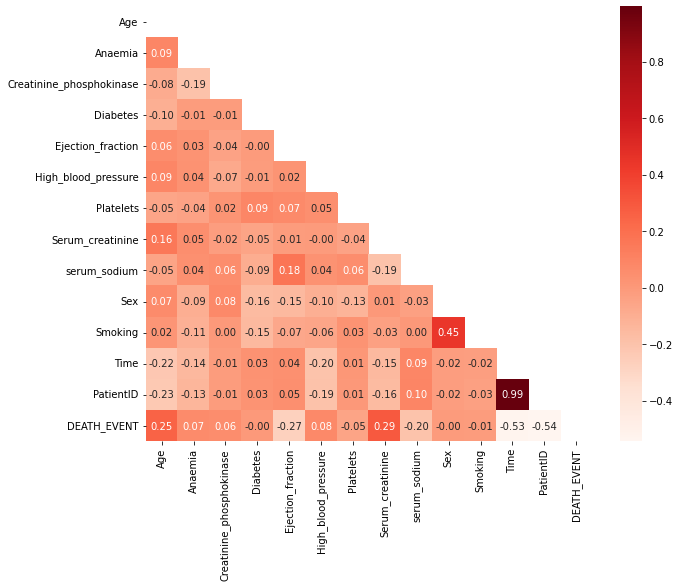

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.select_dtypes('number').corr()
sns.heatmap(corr, mask=np.triu(corr), annot=True, fmt= '.2f', cmap=plt.cm.Reds) 
plt.show()